In [1]:
# import pandas as pd
# import sklearn
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression
# from sklearn.utils import shuffle
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold
# import umap
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
import warnings

# sklearn warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *

2022-12-10 10:27:26.956387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 10:27:27.060878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 10:27:27.060896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-10 10:27:27.075899: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-10 10:27:27.578262: W tensorflow/stream_executor/platform/de

In [3]:
uniqcounts, samplemap, sig, ratio, cov = load_and_preprocess_data()

In [4]:
# some dimensionality reduction (see end of notebook)
(
    embed_cov,
    embed_ratio,
    embed_uniq,
    embed_cov_tsne,
    embed_ratio_tsne,
    embed_uniq_tsne,
    embed_cov_pca,
    embed_ratio_pca,
    embed_uniq_pca,
    embed_ratio_pca,
    embed_uniq_pca,
    embed_sig_pca,
) = get_embeddings(uniqcounts, ratio, cov, sig)

In [5]:
# columns suggested by Zsolt for dimensionality reduction
reduced_cols_sig = [
    "A549_hg38_area",
    "SAEC_hg38_area",
    "colon_cluster507_hg38_area",
    "glomerular_placental_clusters833_890_hg38_area",
    "hematopoietic_specific_liquorice_hg38_area",
    "hepatocyte_all_hg38_area",
    "mammary_epithel_cluster2438_hg38_area",
    "prostate_cluster2483_hg38_area",
    "A549_hg38_depth",
    "SAEC_hg38_depth",
    "colon_cluster507_hg38_depth",
    "hematopoietic_specific_liquorice_hg38_depth",
    "hepatocyte_all_hg38_depth",
    "prostate_cluster2483_hg38_depth",
]

## Overall info

The "pipeline" basically does everything. You can directly use either of uniqcounts, samplemap, sig, ratio, cov as features (or some custom combination as long as it has the same format, ie sample name as index, different features as columns).
It tunes a logistic regression with L1 penalty. The penalty is the "C" parameter. As it is implemented, C is actually inversely proportionnal to the penalty. Higher penalty (thus lower C) means less coefficients are selected, reducing overfittng. A feature is dropped if its coefficient is set to 0. 
The pipeline finds optimal parameters using GridSearch with Leave One Out Cross Validation, but you can easily change the CV strategy and the method to select the best model (here model with overall highest precision, recall and f1).

### Experiment 1: 
Train: all baseline and healthy and some selected HN 6 months

Test: the rest


In [6]:
train_samples, test_samples = train_test_custom(
    samplemap,
    train_indices=[
        "HN1-BL",
        "HN2-BL",
        "HN3-BL",
        "HN4-BL",
        "HN5-BL",
        "HN6-BL",
        "HN7-BL",
        "HV1",
        "HV3",
        "HV4",
        "HV5",
        "HV6",
        "HV7",
        "HV8",
        "OMD1-BL",
        "OMD3-BL",
        "OMD4-BL",
        "OMD5-BL",
        "OMD6-BL",
        "OMD7-BL",
        "OMD8-BL",
        "OMD9-BL",
        "PV1",
        "PV3",
        "PV4",
        "PV5",
        "PV6",
        "PV7",
        "PV8",
        "PV9",
        "HN1-d180",
        "HN3-d180",
        "HN4-d180",
        "HN5-d180",
    ],
)

Initially using 960 features
best parameters {'C': 2}
Number of nonzero coeffs 12
Kept features Int64Index([45, 54, 56, 111, 117, 156, 201, 262, 356, 357, 358, 655], dtype='int64', name='length')
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        27
           1       0.84      0.75      0.79        28

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



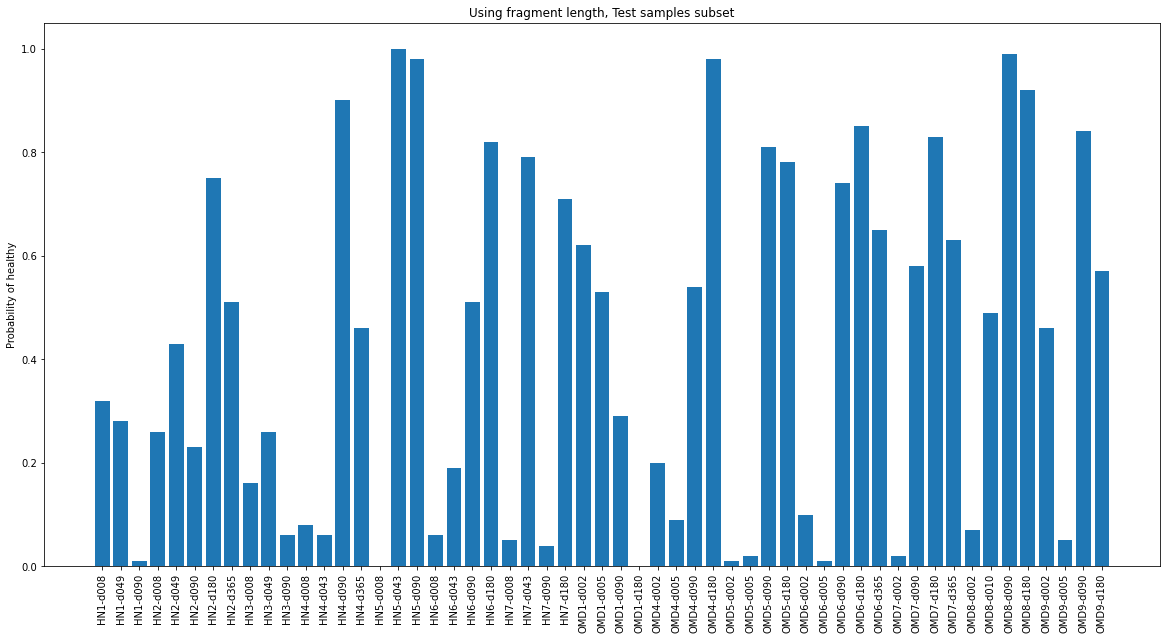

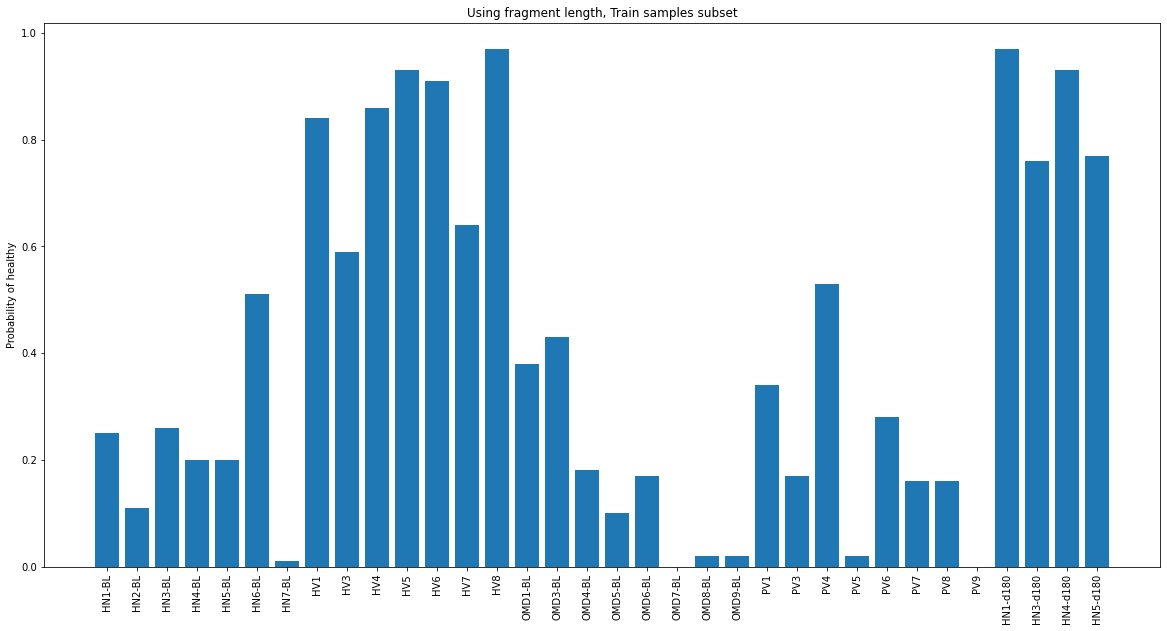

In [7]:
columns_uniqcounts = pipeline(
    uniqcounts, train_samples, test_samples, parameters={"C": [0.1, 1, 2, 5, 10]}
)

### Experiment 2: 
a)
Train : all baselines and healthy except HN

Test : the rest (including all HN samples)

b)
Train : all baselines and healthy

Test : the rest 

Run twice all the cells below, once using train_test with include_hn = True and once with include_hn = False

In [8]:
train_samples, test_samples = train_test(samplemap, include_hn=True)

Using fragment length as features
Initially using 960 features
best parameters {'C': 10}
Number of nonzero coeffs 23
Kept features Int64Index([ 40,  45,  48,  52,  54,  56, 123, 127, 129, 130, 132, 133, 142,
            155, 156, 200, 201, 262, 351, 352, 354, 356, 656],
           dtype='int64', name='length')
              precision    recall  f1-score   support

           0       0.61      0.85      0.71        27
           1       0.81      0.53      0.64        32

    accuracy                           0.68        59
   macro avg       0.71      0.69      0.67        59
weighted avg       0.72      0.68      0.67        59

Using cell signatures as features
Initially using 28 features
best parameters {'C': 1}
Number of nonzero coeffs 7
Kept features Index(['glomerular_placental_clusters833_890_hg38_area',
       'placenta_cluster884_hg38_area', 'HeLa_cluster1777_hg38_depth',
       'SAEC_hg38_depth', 'melano_SOX_clusters1863_2205_hg38_depth',
       'panc_epithel_cluster1974_hg3

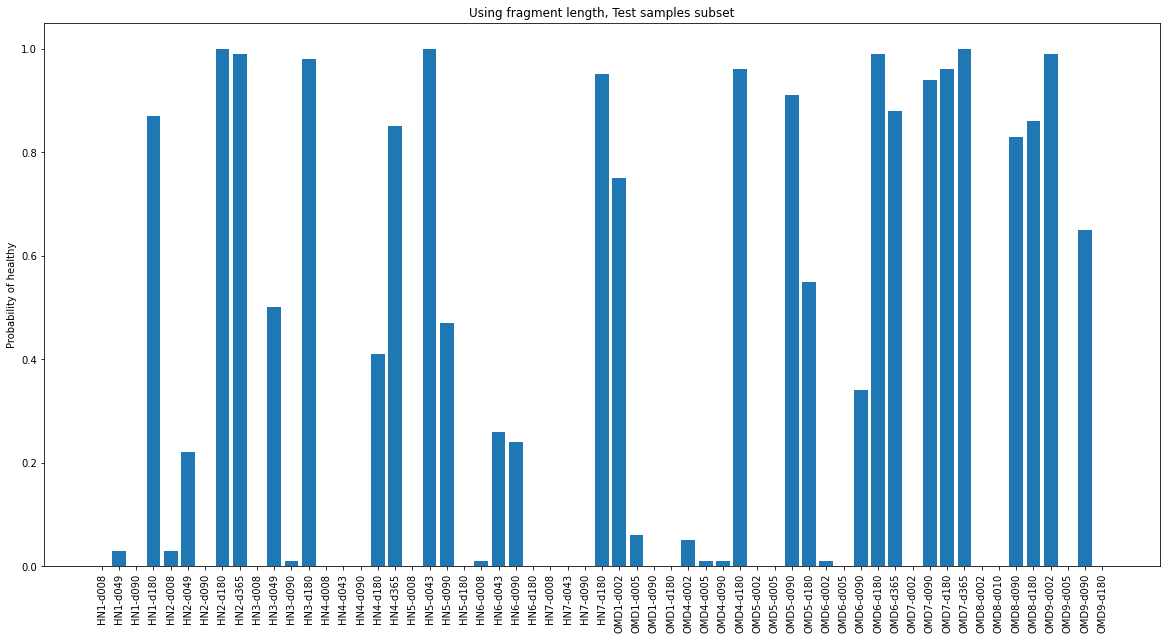

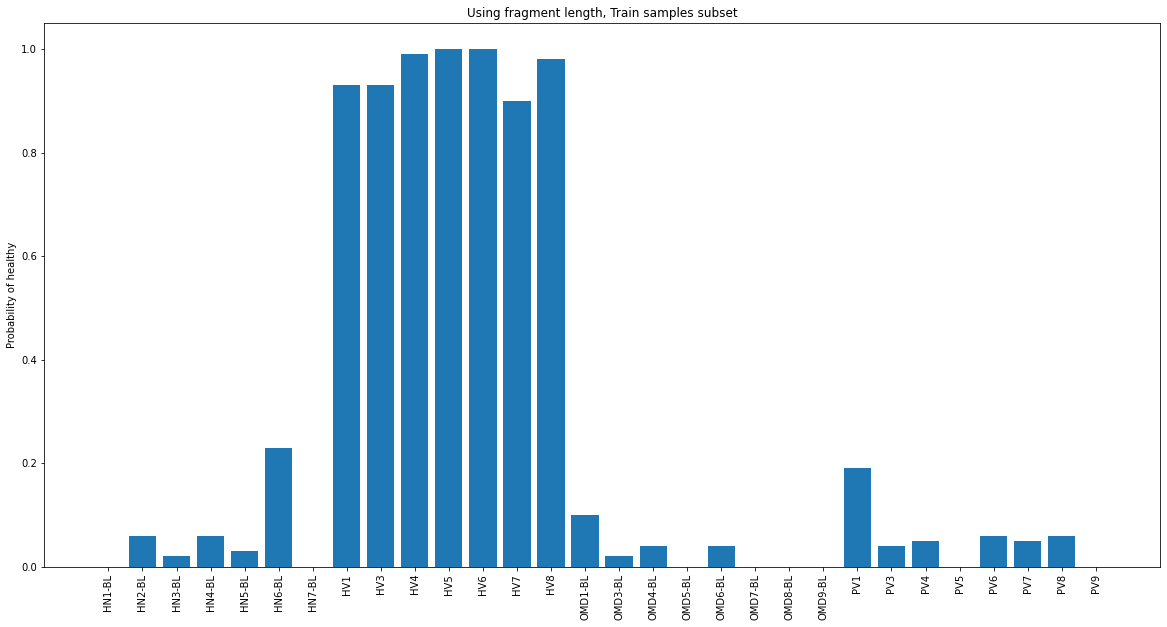

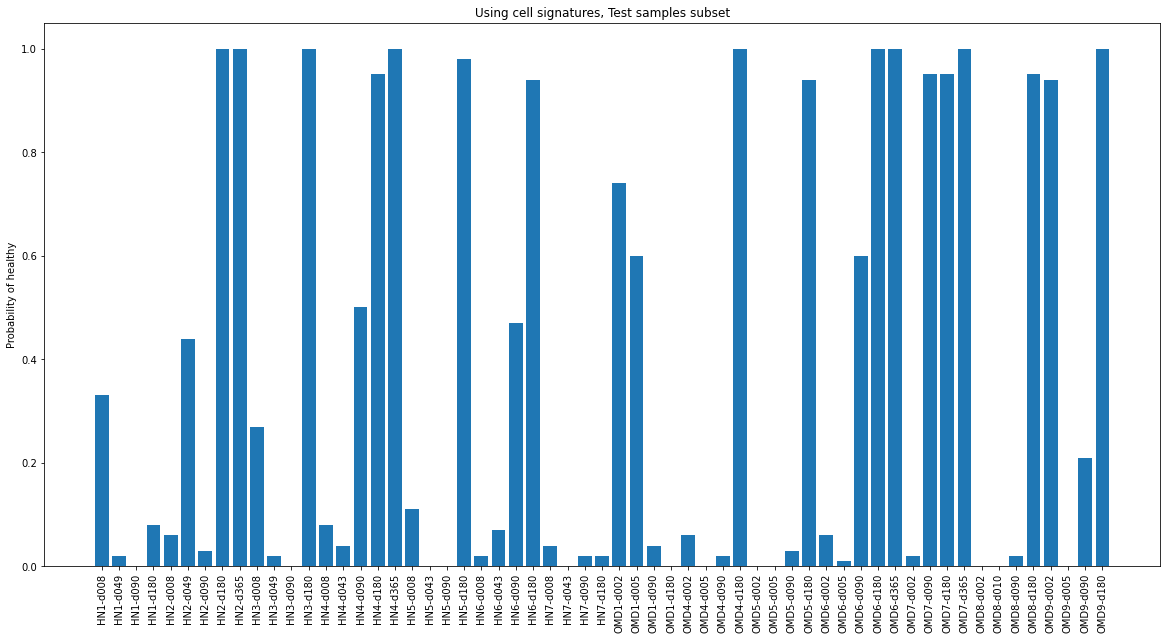

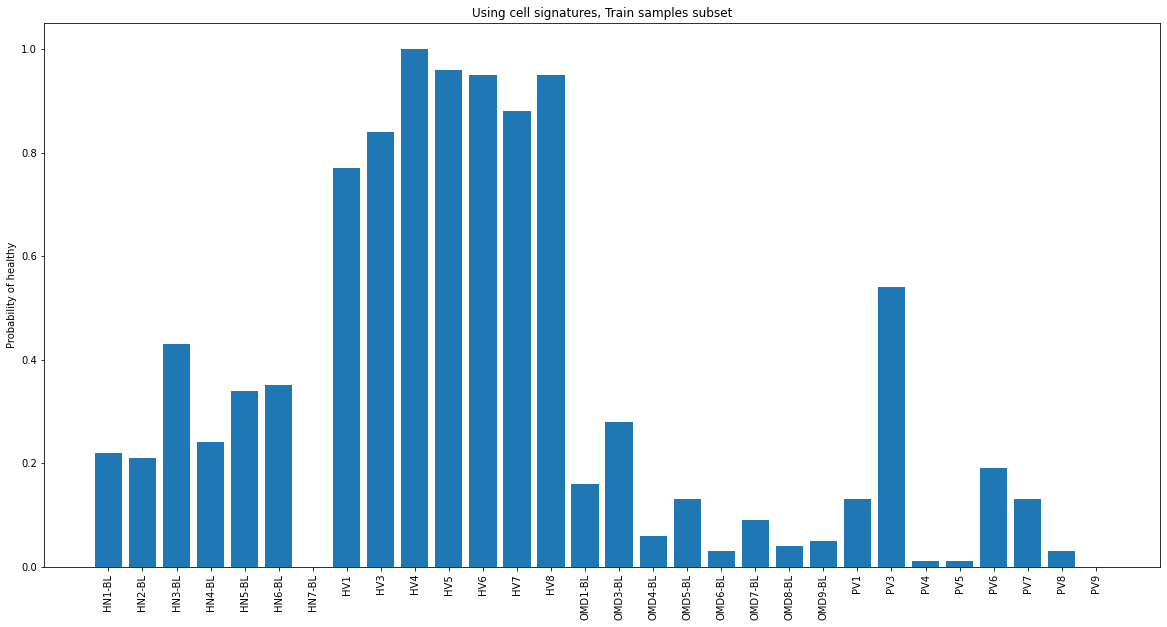

In [9]:
for feature_df in [uniqcounts, sig]:
    print(f"Using {feature_df.name} as features")
    columns_uniqcounts = pipeline(
        feature_df, train_samples, test_samples, parameters={"C": [0.1, 1, 2, 5, 10]}
    )

Initially using 960 features
best parameters {'C': 2}
Number of nonzero coeffs 11
Kept features Int64Index([45, 52, 54, 117, 122, 123, 156, 200, 201, 351, 656], dtype='int64', name='length')
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        27
           1       0.80      0.62      0.70        32

    accuracy                           0.71        59
   macro avg       0.72      0.72      0.71        59
weighted avg       0.73      0.71      0.71        59



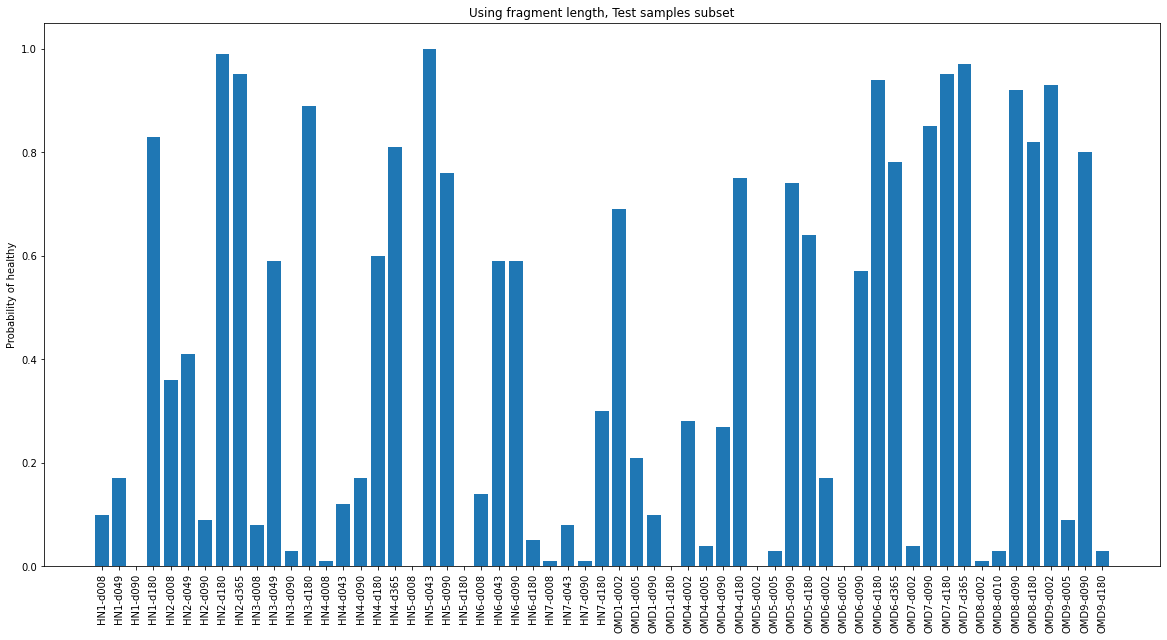

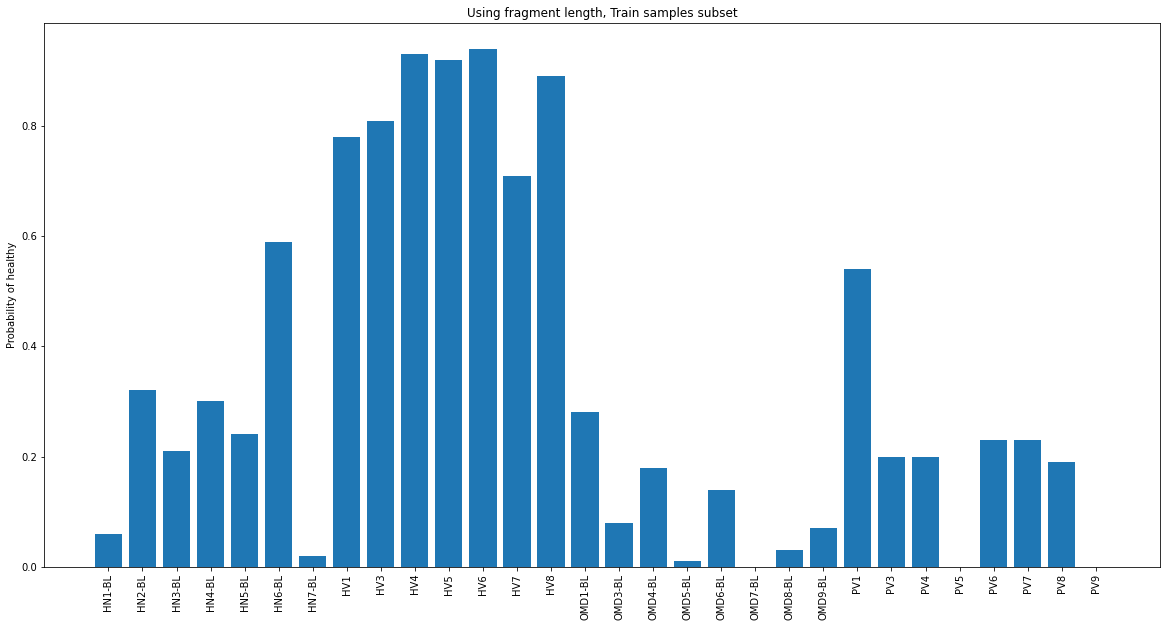

In [10]:
# try to enforce more regularization
columns_uniqcounts = pipeline(
    uniqcounts, train_samples, test_samples, parameters={"C": [2, 3]}
)

Initially using 14 features
best parameters {'C': 10}
Number of nonzero coeffs 13
Kept features Index(['A549_hg38_area', 'SAEC_hg38_area', 'colon_cluster507_hg38_area',
       'glomerular_placental_clusters833_890_hg38_area',
       'hematopoietic_specific_liquorice_hg38_area',
       'hepatocyte_all_hg38_area', 'mammary_epithel_cluster2438_hg38_area',
       'prostate_cluster2483_hg38_area', 'A549_hg38_depth',
       'colon_cluster507_hg38_depth',
       'hematopoietic_specific_liquorice_hg38_depth',
       'hepatocyte_all_hg38_depth', 'prostate_cluster2483_hg38_depth'],
      dtype='object', name='region-set')
              precision    recall  f1-score   support

           0       0.65      0.96      0.78        27
           1       0.95      0.56      0.71        32

    accuracy                           0.75        59
   macro avg       0.80      0.76      0.74        59
weighted avg       0.81      0.75      0.74        59



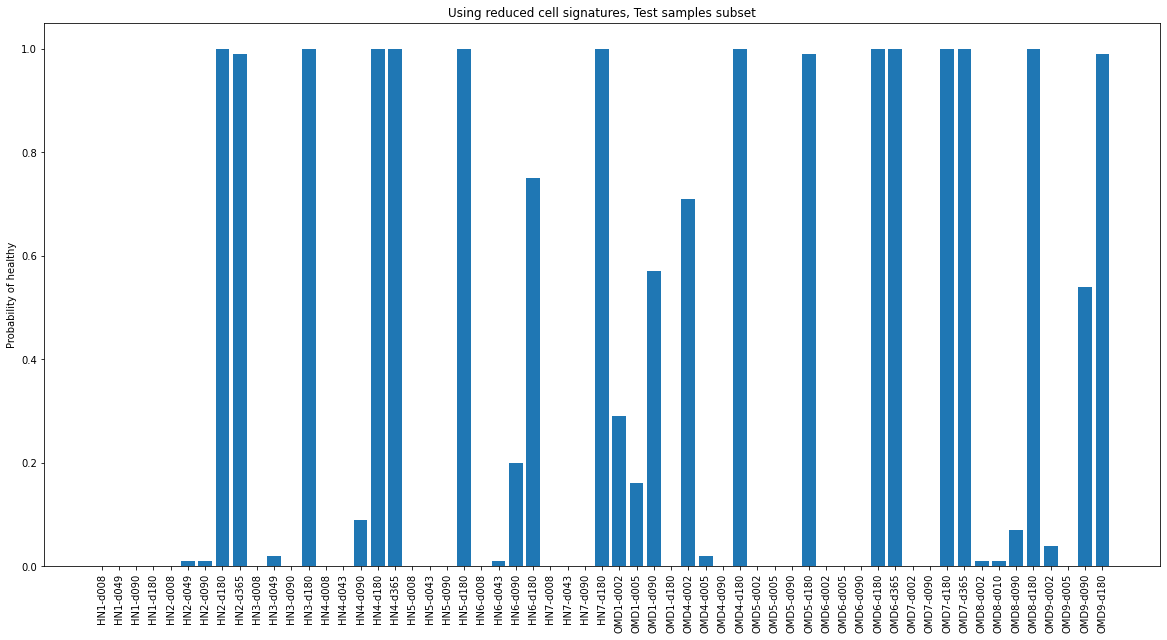

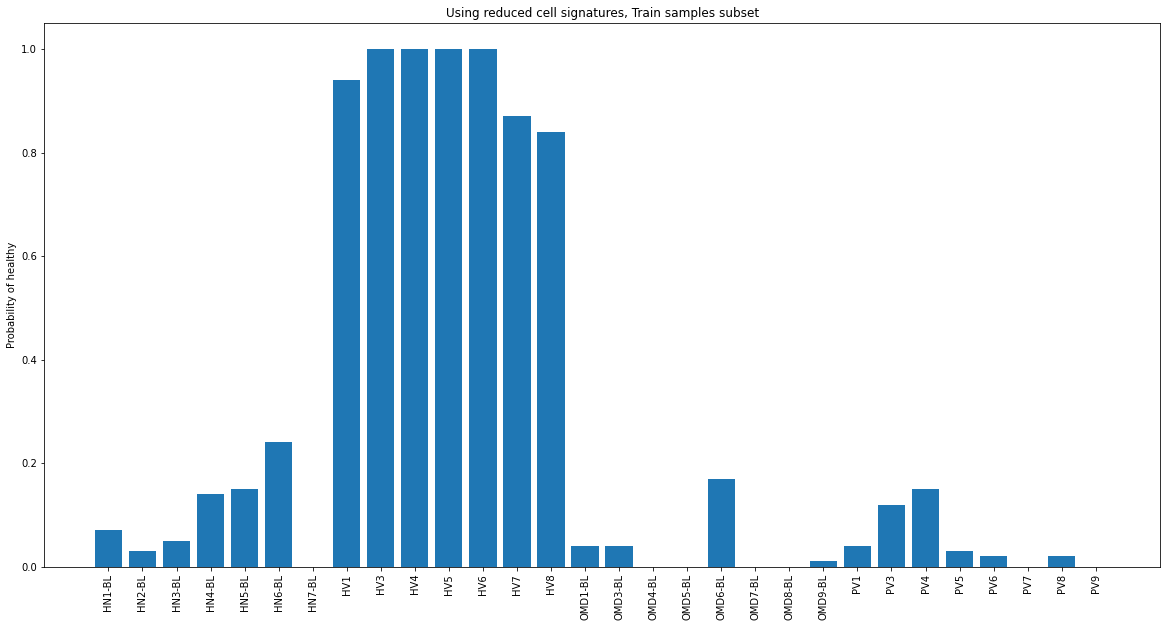

In [11]:
# reduced signatures
features = sig[reduced_cols_sig].copy()
features.name = "reduced cell signatures"
columns_sig_reduced = pipeline(
    features,
    train_samples,
    test_samples,
    parameters={"C": [3, 5, 10]},
)

Initially using 960 features
best parameters {'C': 0.5}
Number of nonzero coeffs 5
Kept features Int64Index([42, 122, 201, 202, 656], dtype='int64', name='length')
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        27
           1       0.56      0.56      0.56        32

    accuracy                           0.53        59
   macro avg       0.52      0.52      0.52        59
weighted avg       0.53      0.53      0.53        59

Int64Index([42, 122, 201, 202, 656], dtype='int64', name='length')


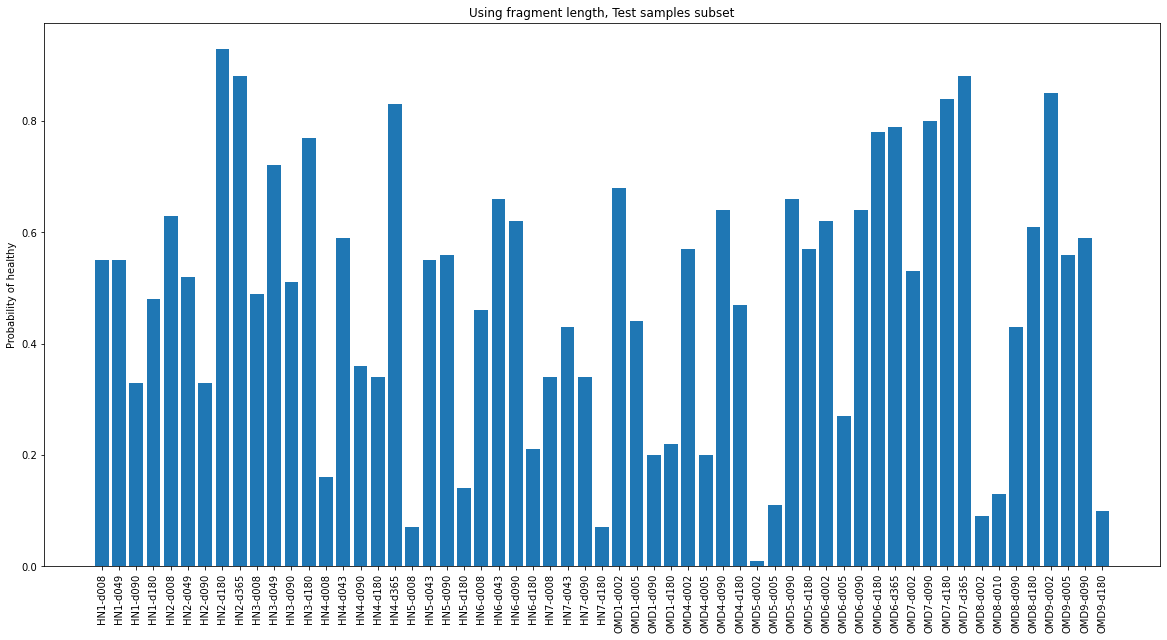

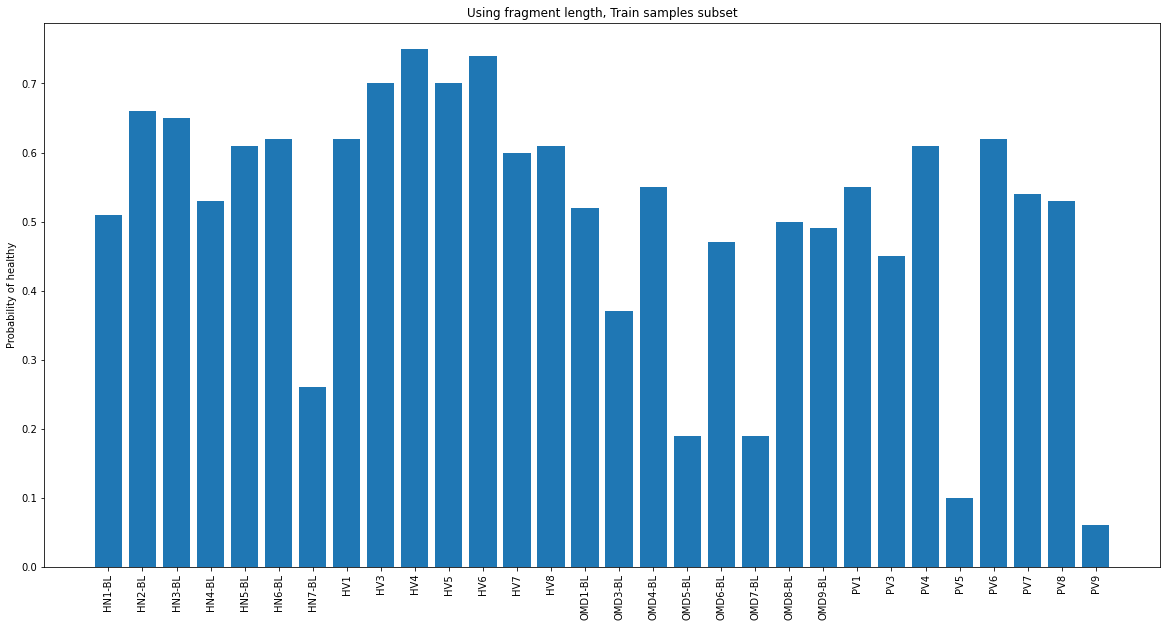

In [12]:
# uniqcounts with more regularization
columns_uniqcounts_reduced = pipeline(
    uniqcounts, train_samples, test_samples, parameters={"C": [0.5]}
)
print(columns_uniqcounts_reduced)

Initially using 24 features
best parameters {'C': 40}
Number of nonzero coeffs 13
Kept features Index([                                              45,
                                                     52,
                                                    117,
                                                    156,
                                                    351,
                                                    656,
                           'colon_cluster507_hg38_area',
       'glomerular_placental_clusters833_890_hg38_area',
                             'hepatocyte_all_hg38_area',
                'mammary_epithel_cluster2438_hg38_area',
                                      'A549_hg38_depth',
                          'colon_cluster507_hg38_depth',
                            'hepatocyte_all_hg38_depth'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.57      0.89      0.70        27
           1       0.82      0.

Index([                                              45,
                                                     52,
                                                    117,
                                                    156,
                                                    351,
                                                    656,
                           'colon_cluster507_hg38_area',
       'glomerular_placental_clusters833_890_hg38_area',
                             'hepatocyte_all_hg38_area',
                'mammary_epithel_cluster2438_hg38_area',
                                      'A549_hg38_depth',
                          'colon_cluster507_hg38_depth',
                            'hepatocyte_all_hg38_depth'],
      dtype='object')

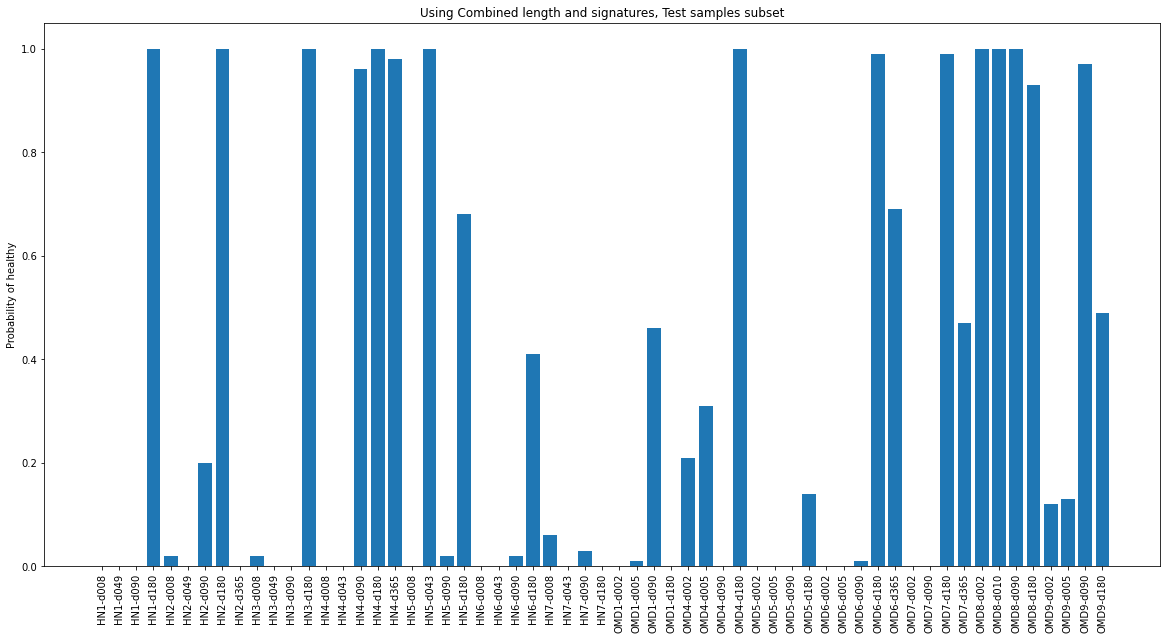

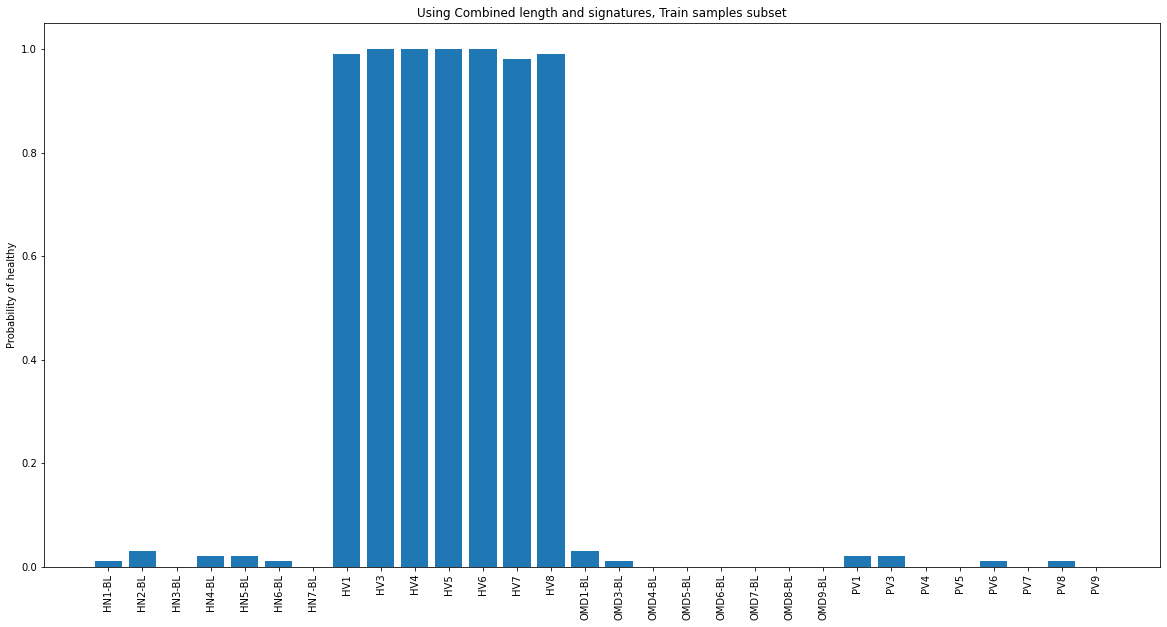

In [13]:
# combining features selected in uniqcounts and sig by the first two models
features = pd.concat((uniqcounts[columns_uniqcounts], sig[columns_sig_reduced]), axis=1)
features.name = "Combined length and signatures"
pipeline(features, train_samples, test_samples)

Initially using 988 features
best parameters {'C': 5}
Number of nonzero coeffs 20
Kept features Index(['glomerular_placental_clusters833_890_hg38_area',
                        'placenta_cluster884_hg38_area',
                'skeletal_muscle_cluster1518_hg38_area',
              'melano_SOX_clusters1863_2205_hg38_depth',
                  'panc_epithel_cluster1974_hg38_depth',
                       'placenta_cluster884_hg38_depth',
               'skeletal_muscle_cluster1518_hg38_depth',
                                                    101,
                                                    102,
                                                    103,
                                                    106,
                                                    107,
                                                    108,
                                                    110,
                                                    111,
                                                 

Index(['glomerular_placental_clusters833_890_hg38_area',
                        'placenta_cluster884_hg38_area',
                'skeletal_muscle_cluster1518_hg38_area',
              'melano_SOX_clusters1863_2205_hg38_depth',
                  'panc_epithel_cluster1974_hg38_depth',
                       'placenta_cluster884_hg38_depth',
               'skeletal_muscle_cluster1518_hg38_depth',
                                                    101,
                                                    102,
                                                    103,
                                                    106,
                                                    107,
                                                    108,
                                                    110,
                                                    111,
                                                    112,
                                                    117,
                               

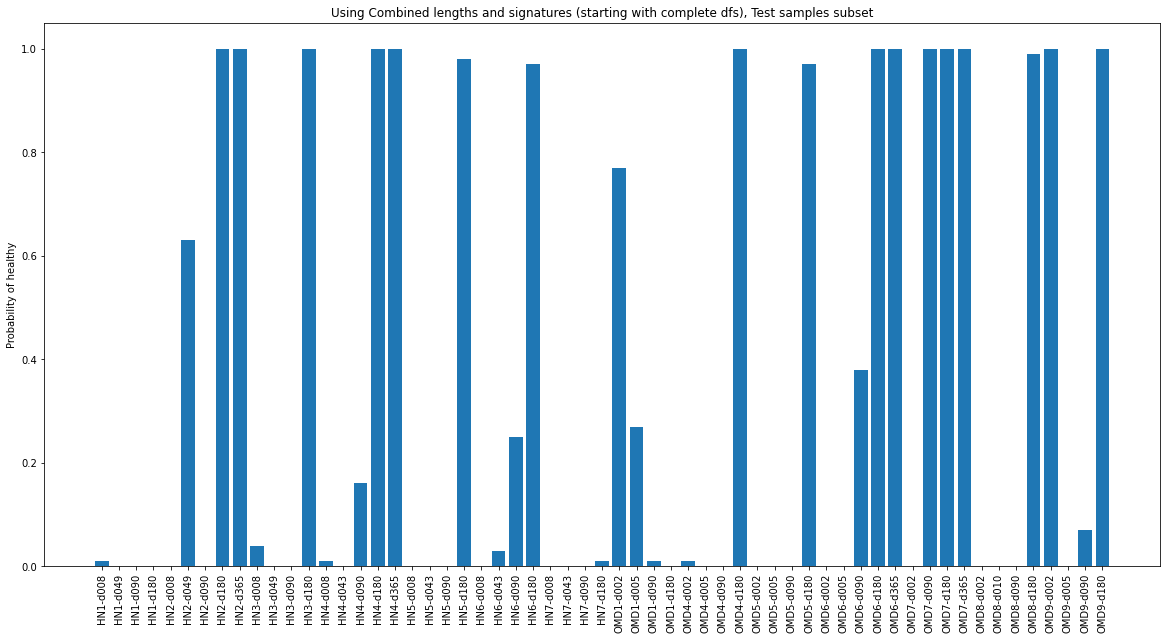

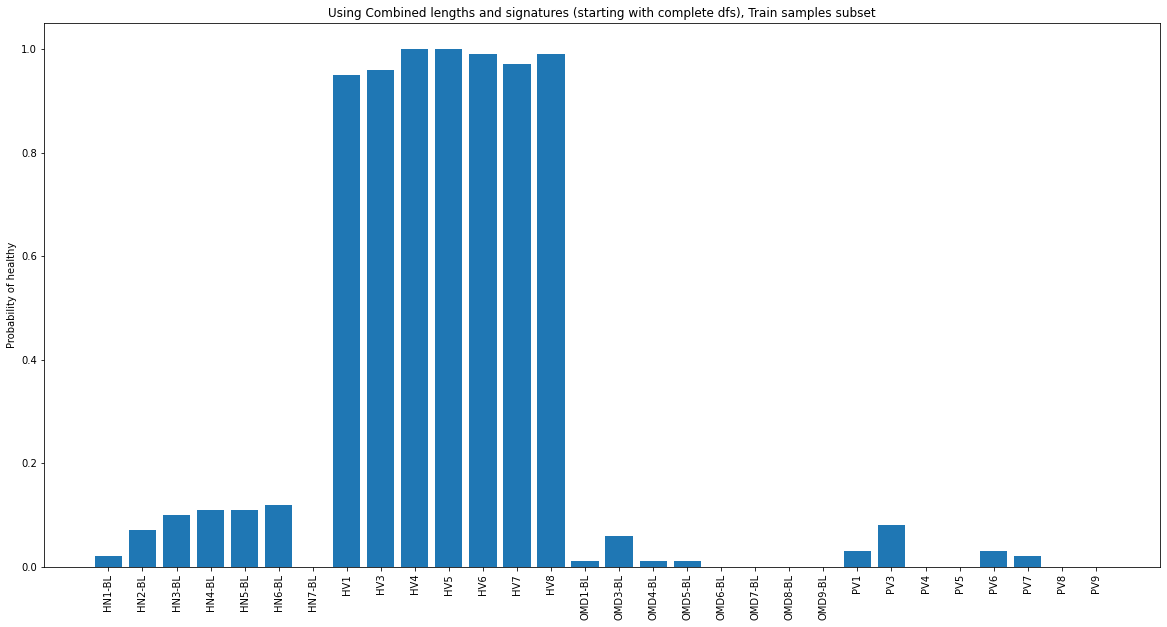

In [14]:
# signatures and uniqcounts (whole dataframes)
features = pd.concat([sig, uniqcounts], axis=1)
features.name = "Combined lengths and signatures (starting with complete dfs)"
pipeline(features, train_samples, test_samples)

Initially using 6 features
best parameters {'C': 7}
Number of nonzero coeffs 5
Kept features Int64Index([70, 110, 250, 280, 0], dtype='int64')
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        27
           1       0.74      0.81      0.78        32

    accuracy                           0.75        59
   macro avg       0.75      0.74      0.74        59
weighted avg       0.75      0.75      0.74        59



Int64Index([70, 110, 250, 280, 0], dtype='int64')

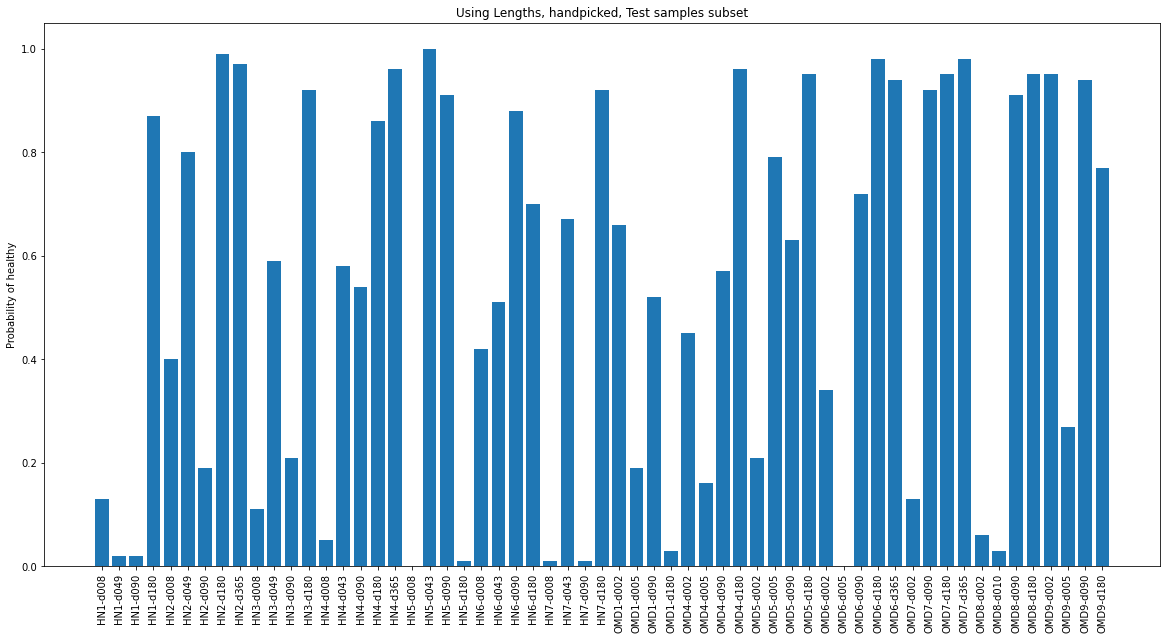

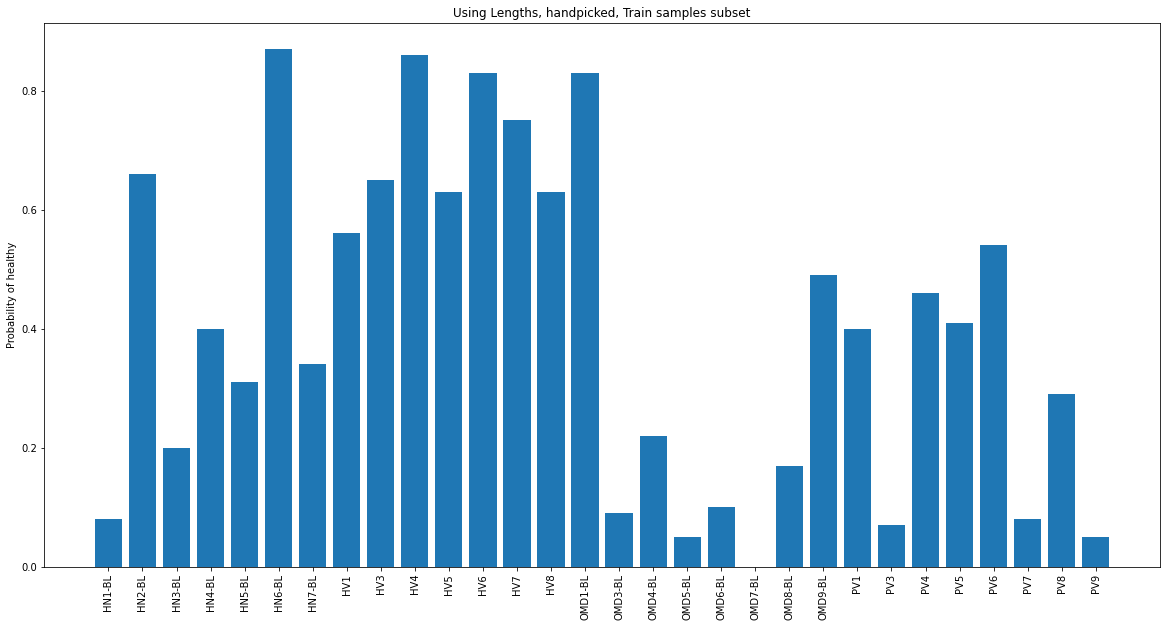

In [15]:
# handpicking some features
features = pd.concat(
    (uniqcounts[[70, 110, 118, 250, 280]], uniqcounts.mean(axis=1)), axis=1
)
features.name = "Lengths, handpicked"
pipeline(
    features, train_samples, test_samples, parameters={"C": [5, 6, 7, 8, 9, 10000]}
)

### Below, some experiments with ratio and coverage, not very convincing

Initially using 28738 features
best parameters {'C': 1}
Number of nonzero coeffs 22
Kept features Index(['chr1_122100001_122200000', 'chr2_92000001_92100000',
       'chr5_71000001_71100000', 'chr6_31200001_31300000',
       'chr6_31700001_31800000', 'chr6_32300001_32400000',
       'chr6_32700001_32800000', 'chr6_58800001_58900000',
       'chr6_59500001_59600000', 'chr7_157600001_157700000',
       'chr8_1100001_1200000', 'chr8_2600001_2700000',
       'chr8_45500001_45600000', 'chr9_67400001_67500000',
       'chr11_52000001_52100000', 'chr14_106400001_106500000',
       'chr15_19100001_19200000', 'chr15_28200001_28300000',
       'chr17_46100001_46200000', 'chr21_5800001_5900000',
       'chr21_6100001_6200000', 'chr22_13700001_13800000'],
      dtype='object', name='chr')
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        27
           1       1.00      0.16      0.27        32

    accuracy                           0.54     

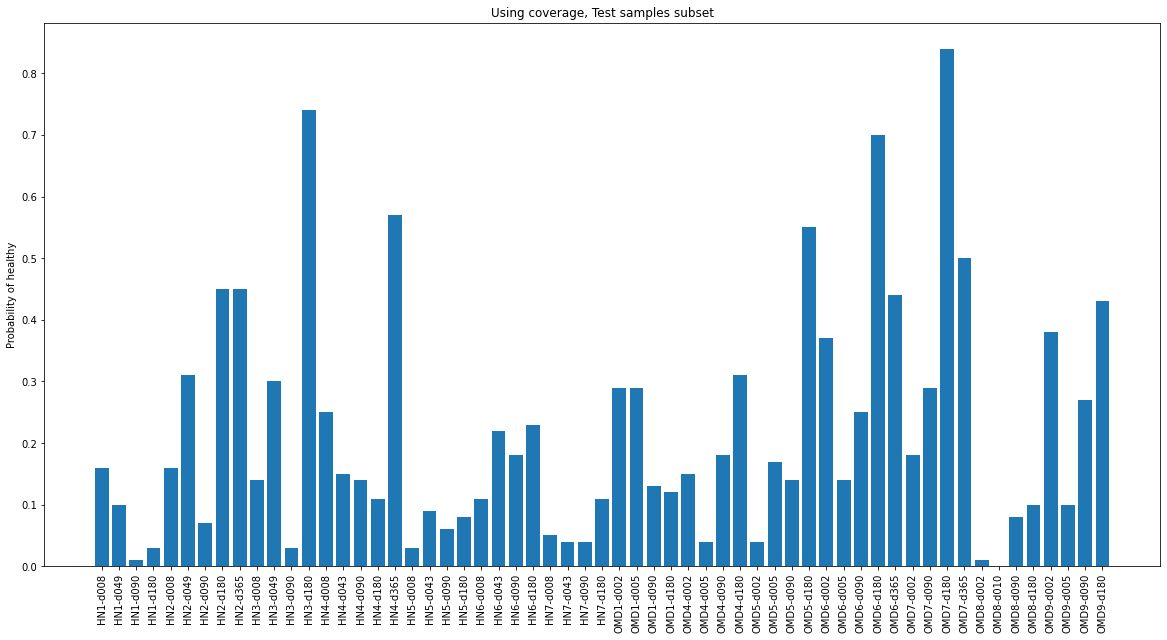

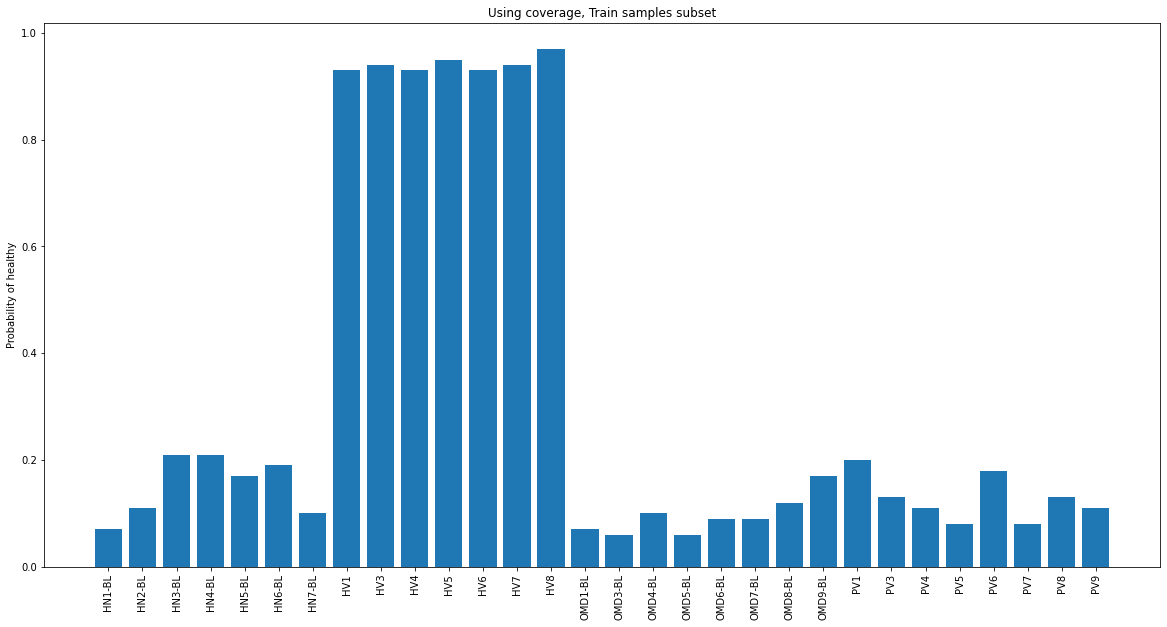

In [16]:
# coverage
columns_cov = pipeline(
    cov, train_samples, test_samples, parameters={"C": [0.5, 1, 2, 10, 100]}
)

Initially using 28738 features
best parameters {'C': 1}
Number of nonzero coeffs 21
Kept features Index(['chr2_87600001_87700000', 'chr3_91700001_91800000',
       'chr4_50800001_50900000', 'chr5_48500001_48600000',
       'chr6_29200001_29300000', 'chr6_31400001_31500000',
       'chr6_58400001_58500000', 'chr6_58800001_58900000',
       'chr6_127800001_127900000', 'chr7_143500001_143600000',
       'chr8_44400001_44500000', 'chr11_7700001_7800000',
       'chr15_18400001_18500000', 'chr15_28500001_28600000',
       'chr16_4200001_4300000', 'chr17_900001_1000000',
       'chr18_17800001_17900000', 'chr18_18600001_18700000',
       'chr19_24900001_25000000', 'chr22_10700001_10800000',
       'chr22_50700001_50800000'],
      dtype='object', name='chr')
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        27
           1       0.62      0.41      0.49        32

    accuracy                           0.54        59
   macro avg       

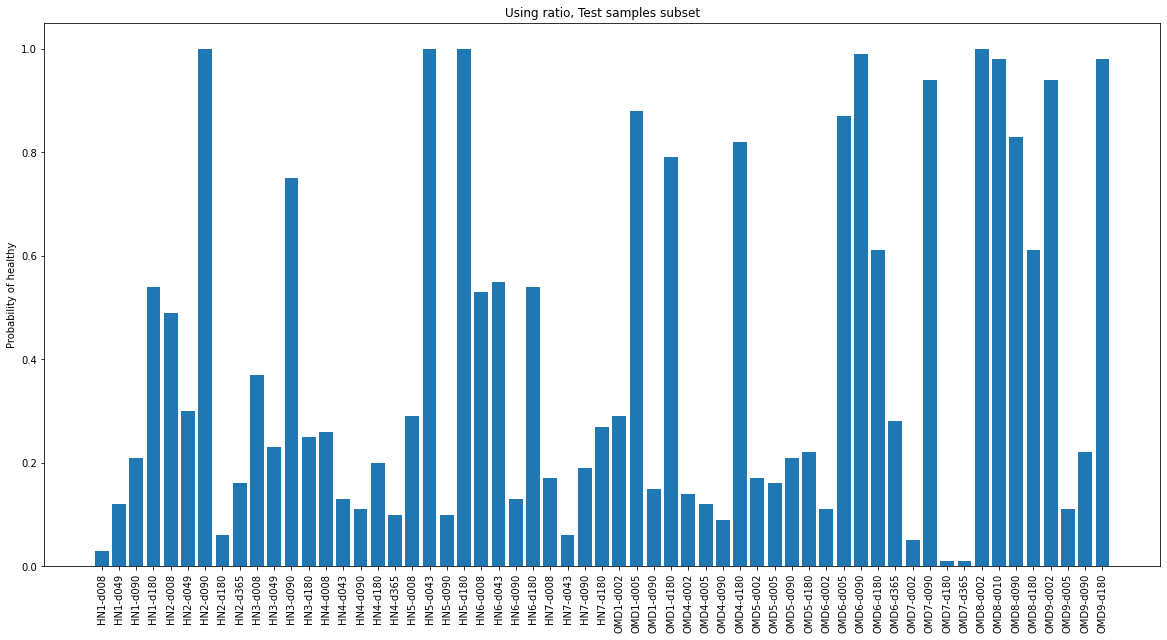

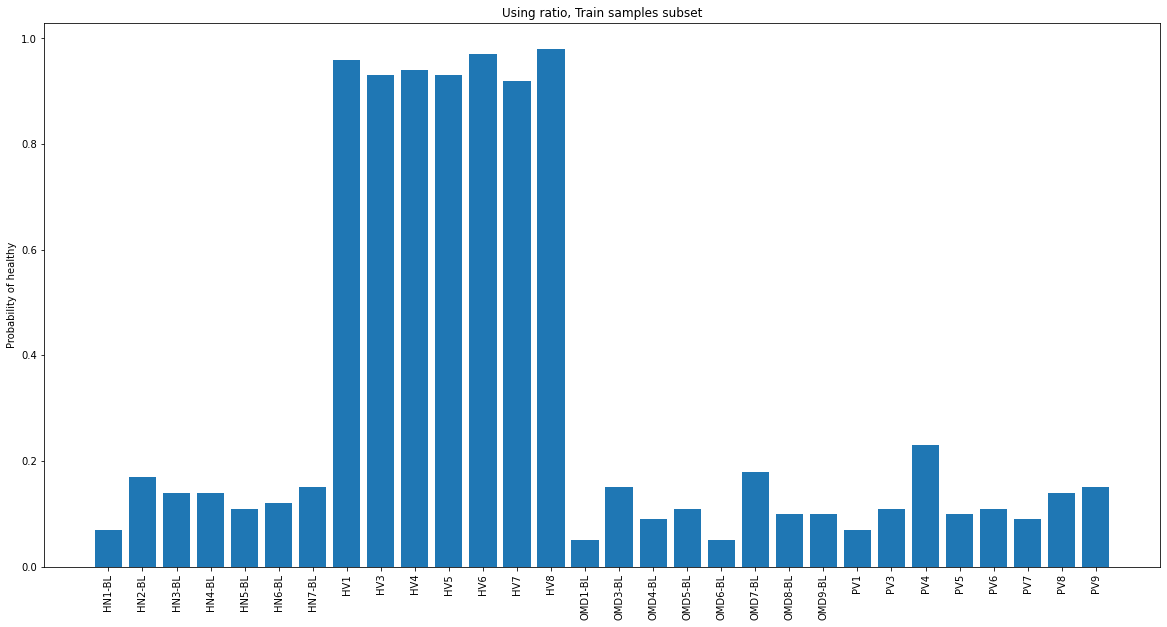

In [17]:
# ratio
columns_ratio = pipeline(
    ratio, train_samples, test_samples, parameters={"C": [0.5, 1, 2, 5]}
)

Initially using 11 features
best parameters {'C': 10}
Number of nonzero coeffs 7
Kept features Int64Index([42, 122, 201, 656, 0, 1, 1], dtype='int64')
              precision    recall  f1-score   support

           0       0.51      0.70      0.59        27
           1       0.64      0.44      0.52        32

    accuracy                           0.56        59
   macro avg       0.57      0.57      0.56        59
weighted avg       0.58      0.56      0.55        59



Int64Index([42, 122, 201, 656, 0, 1, 1], dtype='int64')

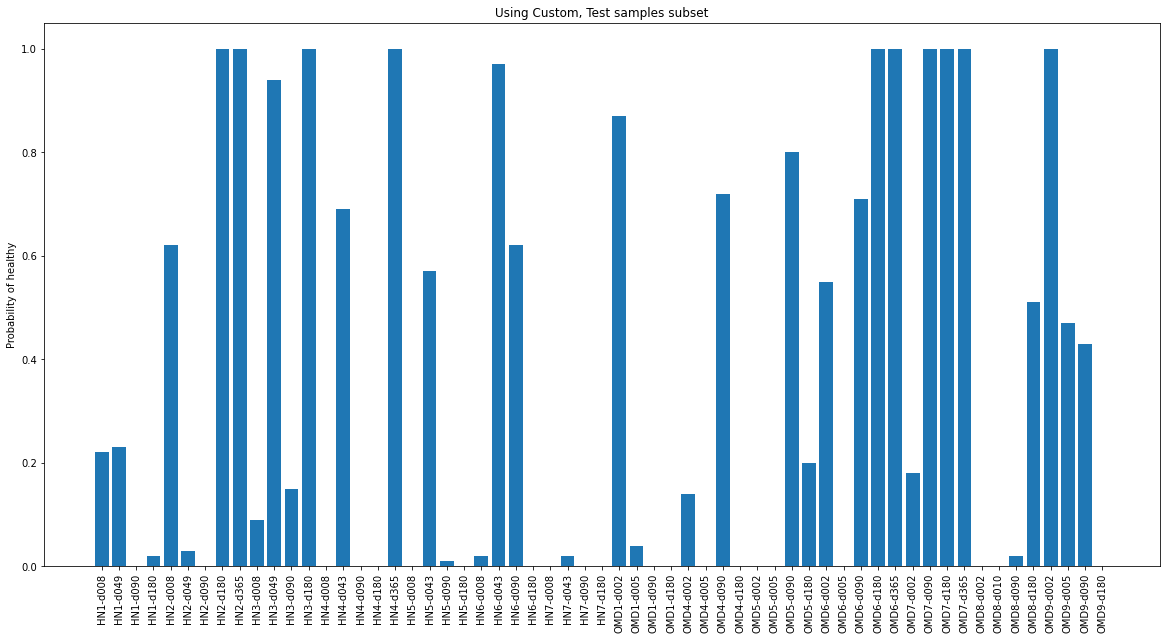

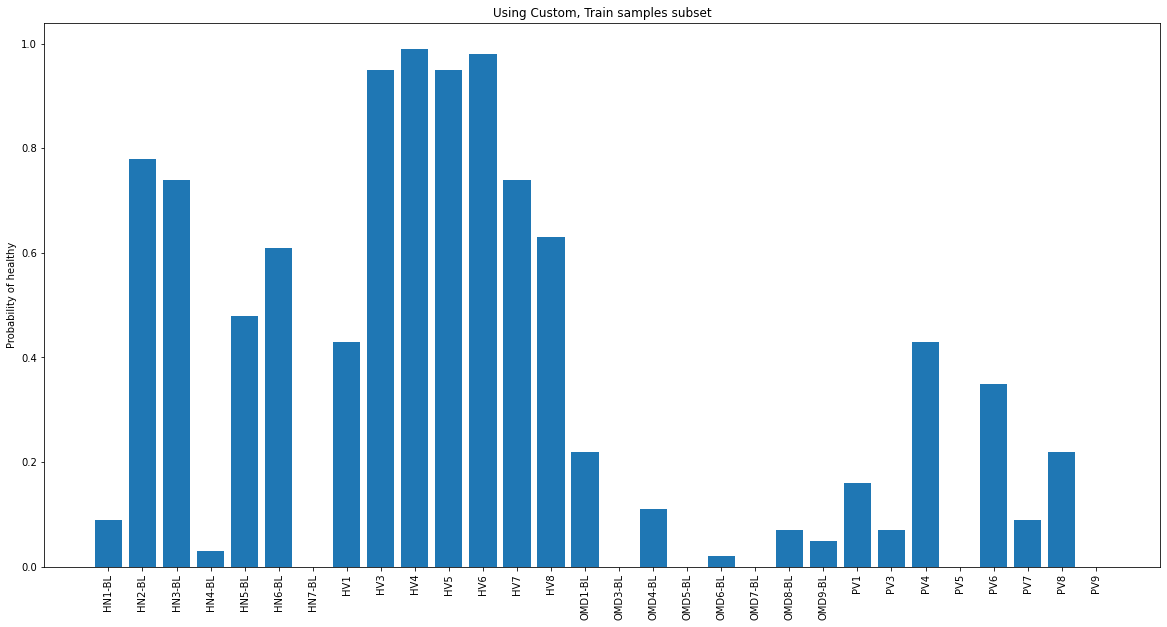

In [18]:
features = pd.concat(
    (
        uniqcounts[columns_uniqcounts_reduced],
        embed_uniq_pca,
        embed_uniq,
        embed_uniq_tsne,
    ),
    axis=1,
)
features.name = "Custom"
pipeline(features, train_samples, test_samples, parameters={"C": [10]})